# Starbucks Capstone Challenge

### <a class="anchor" id="Table of Contents">Table of Contents</a>
1. Introduction
2. Data Sets
3. Data Engineering and Cleaning
4. Exploratory Data Analysis and Visualization
5. FunkSVD (Matrix Factorization)
6. Concluding Reflection and Improvements

### <a class="anchor" id="Introduction">Part I : Introduction</a>

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### My Initial Thoughts and Approach
My objective is to build a machine learning model that can be used to better target users with offers. This will be a recommender system. I will perform the followig the steps:
- First I will clean up the data including some feature engineering
- Then I will explore the data to understand it some and make the above updates
- The I will perform rank based recommendations (basically recommending based on popularity)
- Then I will do collaborative filter using FunkSVD

### <a class="anchor" id="Data Sets">Part II : Data Sets</a>
The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [469]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import pickle
import json
from datetime import datetime
import matplotlib.pyplot as plt 
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [470]:
transcript.shape

(306534, 4)

### <a class="anchor" id="Data Engineering and Cleaning">Part III : Data Engineering and Cleaning</a>
We get some insights into the data and clean up the data.
1. Lets load the data first

In [289]:
def load_data(portfolio_filepath, profile_filepath, transcript_filepath):
    """
    Loads data from the three files
    params
    -------------------------------------------------------------
    :param portfolio_filepath: path to portfolio file
    :param profile_filepath: path to profile fle
    :param transcript_filepath: path to transcript file
    :return: three dataframes for each of the files
    """
    try:
        # Read in the portfolio json file
        portfolio = pd.read_json(portfolio_filepath, orient = 'records', lines = True)

        # Read in the profile json file
        profile = pd.read_json(profile_filepath, orient = 'records', lines = True)

        # Read in the transcript json file
        transcript = pd.read_json(transcript_filepath, orient = 'records', lines = True)

        # A dictionary of dataframes
        df = {'portfolio': portfolio,
              'profile':profile,
              'transcript': transcript}

        return df
    except Exception as e:
        print('{} [ info ] An error has occured with the following details: {}'.format(datetime.now(), e))

In [290]:
portfolio_filepath = "data/portfolio.json"
profile_filepath = "data/profile.json"
transcript_filepath = "data/transcript.json"
df = load_data(portfolio_filepath, profile_filepath, transcript_filepath)
df_portfolio, df_profile, df_transcript = df['portfolio'], df['profile'], df['transcript']

In [291]:
df_profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [292]:
df_portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [293]:
df_profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [460]:
df_transcript.head()

,person,event,value,time,outcome
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0


In [471]:
transcript.shape

(306534, 4)

In [472]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


1 Lets determine how many offers are in the portfolio

In [295]:
df_portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')

In [296]:
# Number of offers in the portfolio
df_portfolio.shape

(10, 6)

In [297]:
df_portfolio.head(11)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


So our portfolio has 10 offers. They differ in terms of:
1. Duration - time for offer to be open in days
2. Reward - given for completing an offer
3. Difficulty - Minimum spend required to complete an offer
4. Channels - The channels on which the offer was valid.

While cleaning the data we can start thinking about:
- Whether or not any of these variables determine whether the offer actioned
- Whether or not customers completing offers without opening them are insensitive to price
But for now we continue cleaning

2. One-hot encode channels and offer type

In [298]:
portfolio = pd.get_dummies(portfolio, columns=['offer_type'])

In [299]:
portfolio.head(10)

,reward,channels,difficulty,duration,id,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
1,10,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
2,0,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,1
3,5,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
4,5,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
5,3,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
6,2,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
7,0,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1
8,5,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
9,2,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0


In [300]:
channels = list(portfolio['channels'])
channels_df = pd.DataFrame( {'channels':channels})
channels_df = pd.get_dummies(channels_df.channels.apply(pd.Series).stack()).sum(level=0)
channels_df

C:\Users\Michael\.conda\envs\disaster_response_proj\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  This is separate from the ipykernel package so we can avoid doing imports until


,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [301]:
portfolio = pd.concat([portfolio, channels_df], axis = 1)
portfolio

,reward,channels,difficulty,duration,id,offer_type_bogo,offer_type_discount,offer_type_informational,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


3. Now drop the channels column, its not required anymore

In [302]:
portfolio.drop(columns = ['channels'], inplace = True)

In [303]:
portfolio.head()

,reward,difficulty,duration,id,offer_type_bogo,offer_type_discount,offer_type_informational,email,mobile,social,web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


In [304]:
portfolio.columns

Index(['reward', 'difficulty', 'duration', 'id', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'email', 'mobile',
       'social', 'web'],
      dtype='object')

Now we write one data clean up function that cleans up the portfolio and does all the above.
These functions will be useful when we build a data pipeline.

In [305]:
def clean_portfolio(portfolio):
    """
    cleans up our portfolio dataset by:
    - performing one-hot encoding on the offer column
    - performing one-hot encoding on the channels column 
    - concaternating the two datasets into a single one
    params
    ---------------------------------------------------------------
    :param portfolio - the portfolio dataframe
    :return clean_portfolio - the the cleaned up portfolio
    """
    # if either offer_type or channels are not in the dataset then
    # we assume portfolio is clean already
    #if not 'offer_type' in portfolio.columns or 'channels' in portfolio.columns:
    #    return portfolio 
    
    portfolio['offer_type_dummy'] = portfolio['offer_type']
    
    # one-hot encoding on offer_type column
    clean_portfolio = pd.get_dummies(portfolio, columns=['offer_type'])
    clean_portfolio = clean_portfolio.rename(columns={'offer_type_dummy':'offer_type'})
    
    # one-hot encoding on channels column
    channels = list(clean_portfolio['channels'])
    channels_df = pd.DataFrame( {'channels':channels})
    channels_df = pd.get_dummies(channels_df.channels.apply(pd.Series).stack()).sum(level=0)
    
    # concate the dataframes here
    clean_portfolio = pd.concat([clean_portfolio, channels_df], axis = 1)
    
    # drop the channels column
    drop_cols = ['channels']
    clean_portfolio.drop(columns = drop_cols, inplace = True)
    
    # return the clean_portfolio
    return clean_portfolio

# lets test to see if this actually worked
df_portfolio = clean_portfolio(df_portfolio)
df_portfolio.head(10)

C:\Users\Michael\.conda\envs\disaster_response_proj\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


,reward,difficulty,duration,id,offer_type_bogo,offer_type_discount,offer_type_informational,email,mobile,social,web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


In [306]:
df_portfolio.isnull().sum()

reward                      0
difficulty                  0
duration                    0
id                          0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
email                       0
mobile                      0
social                      0
web                         0
dtype: int64

4. Now we turn to the profile dataset. 
First how many customer profiles are there?

In [307]:
df_profile.shape

(17000, 5)

5. Lets explore the profiles a bit more, whats the situation with invalid data and nulls.

In [308]:
df_profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


We can see that there are issues with the data in the gender, age and income columns.

In [309]:
df_profile.isnull().mean()

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [310]:
df_profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [311]:
# Lets get rid of the None on the gender column first
df_profile.replace(to_replace=[None], value = np.nan, inplace = True)

In [312]:
df_profile.isnull().mean()

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [313]:
df_profile.head()

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [314]:
df_profile.isnull().mean()

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

Even though age has no nulls, from the above we can see that there are ages, like 118 that look suspect.

In [315]:
df_profile[['id', 'age']].groupby('age').count()

,id
age,
18,70
19,135
20,135
21,140
22,131
...,...
98,5
99,5
100,12


In [316]:
df_profile.replace(to_replace=[118], value = np.nan, inplace = True)

In [317]:
df_profile.isnull().mean()

gender              0.127941
age                 0.127941
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [318]:
df_profile.head()

,gender,age,id,became_member_on,income
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212.0,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712.0,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509.0,100000.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,20170804.0,NaN


In [319]:
df_profile = df_profile[df_profile['gender'].notna()]

In [320]:
df_profile.head()

,gender,age,id,became_member_on,income
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509.0,100000.0
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426.0,70000.0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209.0,53000.0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111.0,51000.0


In [321]:
df_profile.isnull().mean()

gender              0.0
age                 0.0
id                  0.0
became_member_on    0.0
income              0.0
dtype: float64

This means that columns that have gender NaN also happen to have Income and Age as Nan. So deleting them is the best strategy.

6. The number of days a person has been with Starbucks might affect how likely they are to respond to offers. We calculate that here.

In [322]:
import datetime
df_profile['member_since_days'] = datetime.datetime.today().date() - pd.to_datetime(df_profile['became_member_on'], format = '%Y%m%d').dt.date

C:\Users\Michael\.conda\envs\disaster_response_proj\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [323]:
df_profile['member_since_days'] = df_profile['member_since_days']/np.timedelta64(1, 'D')

C:\Users\Michael\.conda\envs\disaster_response_proj\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [324]:
df_profile.head()

,gender,age,id,became_member_on,income,member_since_days
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,1636.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509.0,100000.0,1703.0
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426.0,70000.0,1351.0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209.0,53000.0,1427.0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111.0,51000.0,1517.0


In [325]:
df_profile[['id', 'age']].groupby('age').count()

,id
age,
18.0,70
19.0,135
20.0,135
21.0,140
22.0,131
...,...
97.0,13
98.0,5
99.0,5


In [326]:
def calculate_member_days(df):
    """
    calculate the number of days a profile has been a member. 
    params
    -----------------------------------------------------------------
    param: df - the dataframe with member information
    return: new df with member_since_days added
    """
    import datetime
    # compute the number of days a profile has been a member
    df['member_since_days'] = datetime.datetime.today().date() - pd.to_datetime(df['became_member_on'], format = '%Y%m%d').dt.date
    
    # remove the trailing 'days'format from it
    df['member_since_days'] = df['member_since_days']/np.timedelta64(1, 'D')
    
    return df

def clean_profile(df):
    """
    clean profile
    params
    ---------------------------------------------------------------------
    param: df the profile dataset
    return df cleaned profiles
    """
    # calculate member days first
    df = calculate_member_days(df)
    
    # lets replace the None first
    df.replace(to_replace=[118], value = np.nan, inplace = True)
    df.replace(to_replace=[None], value = np.nan, inplace = True)
    
    # now the nulls can go
    df = df[df['gender'].notna()]
    
    return df

# lets test our clean_profile function
df_profile = clean_profile(df_profile)
df_profile

C:\Users\Michael\.conda\envs\disaster_response_proj\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Michael\.conda\envs\disaster_response_proj\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Michael\.conda\envs\disaster_response_proj\lib\site-packages\pandas\core\frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,gender,age,id,became_member_on,income,member_since_days
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,1636.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509.0,100000.0,1703.0
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426.0,70000.0,1351.0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209.0,53000.0,1427.0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111.0,51000.0,1517.0
...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604.0,54000.0,1312.0
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713.0,72000.0,1273.0
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,20170126.0,73000.0,1806.0
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,20160307.0,50000.0,2131.0


In [327]:
df_profile.isnull().sum()

gender               0
age                  0
id                   0
became_member_on     0
income               0
member_since_days    0
dtype: int64

7. Now we turn to the transcript dataframe

In [448]:
transcript.head(10)

,person,event,value,time,outcome,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0,f19421c1d4aa40978ebb69ca19b0e20d
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,0,2298d6c36e964ae4a3e7e9706d1fb8c2
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,0,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [463]:
transcript.shape

(306534, 4)

In [464]:
transcript.columns

Index(['person', 'event', 'value', 'time'], dtype='object')

In [330]:
unique_events = df_transcript['event'].unique()
unique_events

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [331]:
unique_events = pd.Series(unique_events).to_dict()
unique_events

{0: 'offer received',
 1: 'offer viewed',
 2: 'transaction',
 3: 'offer completed'}

In [332]:
# lets swap them around
unique_events = dict([(value, key) for key, value in unique_events.items()])
unique_events

{'offer received': 0,
 'offer viewed': 1,
 'transaction': 2,
 'offer completed': 3}

In [333]:
# Now lets use these as outcomes in our df. We will use this as a target late
# in our machine learning model
df_transcript['outcome'] = df_transcript['event'].map(unique_events)
df_transcript

,person,event,value,time,outcome
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,2
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,2
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,2
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,2


In [334]:
# now we create a function to perform this mapping in our pipeline
def events_to_outcomes(df):
    """
    maps events to events outcomes so that we can use this later when reframe
    this problem as a classification problem
    params
    --------------------------------------------------------------------
    param: df dataframe of transripts
    return: datafram with mapping of events to outcomes
    """
    # first we extract our events here
    unq_events = df['event'].unique()
    unq_events = pd.Series(unq_events).to_dict()
    
    # lets swap around the keys and values so we map in the dataframe
    unq_events = dict([(value, key) for key, value in unq_events.items()])
    
    # now for the magic
    df['outcome'] = df['event'].map(unq_events)
    
    # return our new data_frame
    return df

# lets test this
df_transcript = events_to_outcomes(df_transcript)
df_transcript.head(10)
    

,person,event,value,time,outcome
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0


In [335]:
df_transcript.isnull().sum()

person     0
event      0
value      0
time       0
outcome    0
dtype: int64

In [336]:
set(list(df_transcript['event']))

{'offer completed', 'offer received', 'offer viewed', 'transaction'}

7. Lets see whats happening in the value column.

In [337]:
normalized_values = pd.json_normalize(df_transcript['value'])
normalized_values

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN


In [338]:
normalized_values['offer_id'] = normalized_values['offer id'][normalized_values['offer_id'].isnull()]
normalized_values

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN


In [339]:
# Now drop the 'offer id ' column
normalized_values.drop(columns=['offer id'], inplace = True)
normalized_values

,amount,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...
306529,1.59,NaN,NaN
306530,9.53,NaN,NaN
306531,3.61,NaN,NaN
306532,3.53,NaN,NaN


In [340]:
# Now we merge the normalized_values dataframe back into transcript dataframe
df_transcript = pd.concat([df_transcript, normalized_values], axis=1)
df_transcript

,person,event,value,time,outcome,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,2,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,2,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,2,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,2,3.53,NaN,NaN


In [341]:
# Now we dont need the value column anymore.
df_transcript.drop(columns = ['value'], inplace = True)
df_transcript

,person,event,time,outcome,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,2,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,2,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,2,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,2,3.53,NaN,NaN


In [342]:
df_transcript


,person,event,time,outcome,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,2,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,2,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,2,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,2,3.53,NaN,NaN


In [343]:
df_transcript = pd.get_dummies(df_transcript, columns = ['event'])
df_transcript

,person,time,outcome,amount,offer_id,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,2,1.59,NaN,NaN,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,2,9.53,NaN,NaN,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,714,2,3.61,NaN,NaN,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,2,3.53,NaN,NaN,0,0,0,1


In [344]:
df_transcript

,person,time,outcome,amount,offer_id,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,2,1.59,NaN,NaN,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,2,9.53,NaN,NaN,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,714,2,3.61,NaN,NaN,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,2,3.53,NaN,NaN,0,0,0,1


In [345]:
def clean_transcript(df):
    """
    cleans the transcript dataframe
    params
    --------------------------------------------------------------
    param: df the transcript data
    return df clean dataframe
    """
    # 1) first we do our event to outcomes mapping
    df = events_to_outcomes(df)
    
    # 2) Normalize values
    normalized_values = pd.json_normalize(df['value'])
    normalized_values['offer_id'] = normalized_values['offer id'][normalized_values['offer_id'].isnull()]
    
    # 3) Drop offer id column
    drop_cols = ['offer id']
    normalized_values.drop(columns=drop_cols, inplace = True)
    
    # 4) merge normalized values dataframe back into transcript dataframe
    df = pd.concat([df, normalized_values], axis=1)
    
    # 5) drop the value column
    drop_cols = ['value']
    df.drop(columns = drop_cols, inplace = True)
    
    # 6) One-hot encoding for event column
    df = pd.get_dummies(df, columns = ['event'])
    df = df.rename(columns={'event_offer completed':'offer completed', 
                            'event_offer received':'offer received', 
                            'event_offer viewed':'offer viewed', 
                            'event_transaction':'transaction'})
    
    # 7) return our new clean data frame
    return df
# lets test our transcript cleaning function here
df_transcript = clean_transcript(transcript)
df_transcript

,person,time,outcome,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,2,1.59,NaN,NaN,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,2,9.53,NaN,NaN,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,714,2,3.61,NaN,NaN,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,2,3.53,NaN,NaN,0,0,0,1


In [447]:
df_transcript.loc[306527]

person                      24f56b5e1849462093931b164eb803b5
event                                        offer completed
value      {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
time                                                     714
outcome                                                    3
Name: 306527, dtype: object

In [346]:
def data_cleaning_pipeline(df_portfolio, df_profile, df_transcript):
    """
    perform all our data cleaning functions in a pipeline and return a single dataset for processing and saving to some db
    """
    
    # clean portfolio
    df_portfolio = clean_portfolio(df_portfolio)
    
    # clean profile
    #df_profile = calculate_member_days(df_profile)
    df_profile = clean_profile(df_profile)
    
    # clean transcript
    df_transcript = clean_transcript(df_transcript)
   
    # merge all datasets into a single one
    df = pd.merge(df_transcript, df_portfolio, how='left', left_on='offer_id', right_on='id')
    drop_cols = ['id']
    df.drop(columns=drop_cols, inplace = True)
    
    df = pd.merge(df_profile, df, how='right', left_on='id', right_on='person')
    
    # lets remove transactions where biographic information is not present
    df = df[df['gender'].notna()]
    df.drop(columns=drop_cols, inplace = True)
    
    # return our new merged df
    return df

# lets test of pipeline
portfolio_filepath = "data/portfolio.json"
profile_filepath = "data/profile.json"
transcript_filepath = "data/transcript.json"
df = load_data(portfolio_filepath, profile_filepath, transcript_filepath)
df_portfolio, df_profile, df_transcript = df['portfolio'], df['profile'], df['transcript']
df = data_cleaning_pipeline(df_portfolio, df_profile, df_transcript)
df

C:\Users\Michael\.conda\envs\disaster_response_proj\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


,gender,age,became_member_on,income,member_since_days,person,time,outcome,amount,offer_id,...,reward_y,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,email,mobile,social,web
0,F,75.0,20170509.0,100000.0,1703.0,78afa995795e4d85b5d9ceeca43f5fef,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,5.0,7.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,M,68.0,20180426.0,70000.0,1351.0,e2127556f4f64592b11af22de27a7932,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,...,2.0,10.0,7.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
5,M,65.0,20180209.0,53000.0,1427.0,389bc3fa690240e798340f5a15918d5c,0,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,...,5.0,5.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
7,M,58.0,20171111.0,51000.0,1517.0,2eeac8d8feae4a8cad5a6af0499a211d,0,0,NaN,3f207df678b143eea3cee63160fa8bed,...,0.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
8,F,61.0,20170911.0,57000.0,1578.0,aa4862eba776480b8bb9c68455b8c2e1,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,5.0,20.0,10.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306527,F,48.0,20171228.0,80000.0,1470.0,24f56b5e1849462093931b164eb803b5,714,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306529,M,66.0,20180101.0,47000.0,1466.0,b3a1272bc9904337b331bf348c3e8c17,714,2,1.59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,M,52.0,20180408.0,62000.0,1369.0,68213b08d99a4ae1b0dcb72aebd9aa35,714,2,9.53,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,F,63.0,20130922.0,52000.0,3028.0,a00058cf10334a308c68e7631c529907,714,2,3.61,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [347]:
df.head(20)

,gender,age,became_member_on,income,member_since_days,person,time,outcome,amount,offer_id,...,reward_y,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,email,mobile,social,web
0,F,75.0,20170509.0,100000.0,1703.0,78afa995795e4d85b5d9ceeca43f5fef,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,5.0,7.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,M,68.0,20180426.0,70000.0,1351.0,e2127556f4f64592b11af22de27a7932,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,...,2.0,10.0,7.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
5,M,65.0,20180209.0,53000.0,1427.0,389bc3fa690240e798340f5a15918d5c,0,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,...,5.0,5.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
7,M,58.0,20171111.0,51000.0,1517.0,2eeac8d8feae4a8cad5a6af0499a211d,0,0,NaN,3f207df678b143eea3cee63160fa8bed,...,0.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
8,F,61.0,20170911.0,57000.0,1578.0,aa4862eba776480b8bb9c68455b8c2e1,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,5.0,20.0,10.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
9,F,62.0,20160211.0,71000.0,2156.0,31dda685af34476cad5bc968bdb01c53,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,5.0,20.0,10.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
12,M,64.0,20170909.0,100000.0,1580.0,4b0da7e80e5945209a1fdddfe813dbe0,0,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,...,10.0,10.0,7.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
13,F,78.0,20170616.0,71000.0,1665.0,c27e0d6ab72c455a8bb66d980963de60,0,0,NaN,3f207df678b143eea3cee63160fa8bed,...,0.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
14,F,88.0,20170518.0,53000.0,1694.0,d53717f5400c4e84affdaeda9dd926b3,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,5.0,20.0,10.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
15,M,42.0,20130811.0,69000.0,3070.0,f806632c011441378d4646567f357a21,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,...,2.0,10.0,10.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


In [348]:
df.isnull().sum()

gender                           0
age                              0
became_member_on                 0
income                           0
member_since_days                0
person                           0
time                             0
outcome                          0
amount                      148805
offer_id                    156401
reward_x                    240318
offer completed                  0
offer received                   0
offer viewed                     0
transaction                      0
reward_y                    156401
difficulty                  156401
duration                    156401
offer_type_bogo             156401
offer_type_discount         156401
offer_type_informational    156401
email                       156401
mobile                      156401
social                      156401
web                         156401
dtype: int64

In [349]:
df[df['outcome'] == 3][['reward_x', 'reward_y']]

,reward_x,reward_y
12658,2.0,NaN
12672,2.0,NaN
12679,5.0,NaN
12692,10.0,NaN
12697,10.0,NaN
...,...,...
306456,5.0,NaN
306470,2.0,NaN
306475,3.0,NaN
306509,2.0,NaN


### <a class="anchor" id="Exploratory-Data-Analysis">Part II : Exploratory Data Analysis and Visualization </a>
We get some insights into the data and clean up the data.
1. How many offers are in the portfolio

Text(0, 0.5, 'Frequency')

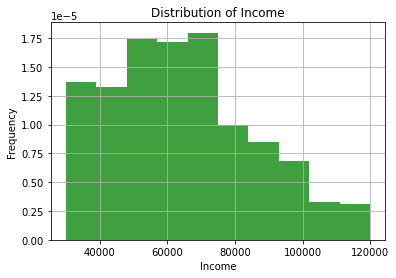

In [350]:
df.income.hist(density=True, facecolor='g', alpha=0.75)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

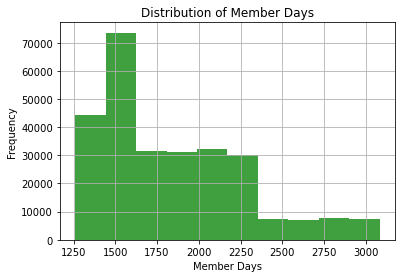

In [351]:
df.member_since_days.hist(facecolor='g', alpha=0.75)
plt.title('Distribution of Member Days')
plt.xlabel('Member Days')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

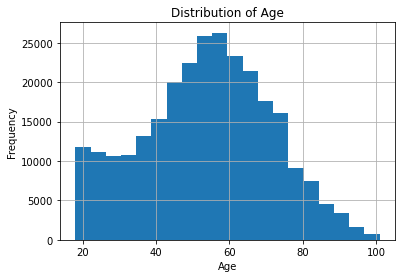

In [352]:
df.age.hist(bins=20)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

<AxesSubplot:title={'center':'Distribution of Income By Age'}, xlabel='age'>

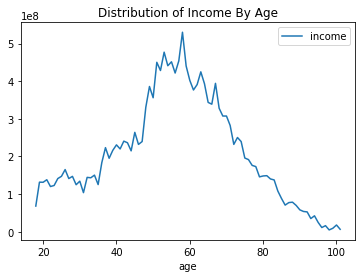

In [353]:
df[['age', 'income']].groupby('age').sum().plot(title='Distribution of Income By Age')

Text(0.5, 1.0, 'Distribution of Gender')

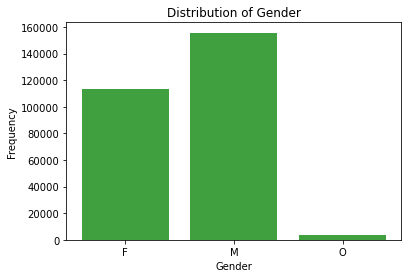

In [354]:
gender = df[['gender', 'person']].groupby('gender').count()
labels = gender.index
X = np.arange(len(gender))
Y = gender['person']
plt.bar(X, Y, facecolor='g', alpha=0.75)
plt.xticks(X, labels)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Distribution of Gender')

In [355]:
df.columns

Index(['gender', 'age', 'became_member_on', 'income', 'member_since_days',
       'person', 'time', 'outcome', 'amount', 'offer_id', 'reward_x',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'reward_y', 'difficulty', 'duration', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'email', 'mobile',
       'social', 'web'],
      dtype='object')

Text(0, 0.5, 'Frequency')

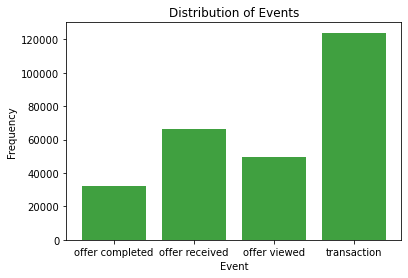

In [356]:
events = df[['offer completed', 
    'offer received',
   'offer viewed',
   'transaction']].sum()
labels = events.index
X = np.arange(len(labels))
Y = events
plt.bar(X, Y, facecolor='g', alpha=0.75)
plt.title('Distribution of Events')
plt.xticks(X, labels)
plt.xlabel('Event')
plt.ylabel('Frequency')


In [357]:
events

offer completed     32444
offer received      66501
offer viewed        49860
transaction        123957
dtype: int64

In [358]:
print('Offer Viewed as a percentage of Offer Received', (events['offer viewed']/events['offer received'])*100, '%')
print('Offer Completed as a percentage of Offer Received', (events['offer completed']/events['offer received'])*100, '%')
print('Offer Completed as a percentage of Offer Viewed', (events['offer completed']/events['offer viewed'])*100, '%')

Offer Viewed as a percentage of Offer Received 74.97631614562187 %
Offer Completed as a percentage of Offer Received 48.787236282161174 %
Offer Completed as a percentage of Offer Viewed 65.07019655034095 %


### <a class="anchor" id="User Based Collaborative Filtering">Part IV: FunkSVD (Matrix Factorization)</a>
We get some insights into the data and clean up the data.
1. We want to reformat our dataframe to be shaped with users as rows and offers as the columns:
- Each user should only appear in each row once
- Each offer should only show up once in one column
- If a user has interacted with an offer once, then we place a 1 where the user-row meets the offer-column. It does not matter how many times a user interacted with an offer, all entries where a user has interacted with an offer should be a 1
- If a user has not interacted with an item, then we place a zero where the user-row meets for that article-column
We use the tests to make sure the basic structure of the matrix matches what is expected by the solution

In [473]:
df.shape

(272762, 25)

In [474]:
transcript.shape

(306534, 4)

In [475]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [476]:
def clean_transcript(transcript):
    transcript = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    return transcript

transcript = clean_transcript(transcript)
transcript

C:\Users\Michael\.conda\envs\disaster_response_proj\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},714,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4


In [480]:
transcript.shape

(167581, 5)

In [482]:
transcript[['person', 'event', 'offer_id']]

,person,event,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,fafdcd668e3743c1bb461111dcafc2a4


In [483]:
# Lets run a few scenarios and test our dataframe
user_item_matrix = transcript.groupby(['person', 'offer_id'])['event'].count().unstack()
user_item_matrix.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,2.0,2.0,NaN,2.0,NaN,NaN,3.0,3.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,3.0,3.0,NaN,2.0,NaN,2.0,3.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,3.0,2.0,NaN,1.0,NaN,5.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,3.0,NaN,NaN,NaN,2.0,3.0,NaN,3.0,NaN


In [484]:
user_item_matrix.shape

(16994, 10)

In [365]:
df_portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [366]:
user_item_matrix = user_item_matrix.fillna(0)
# Lets ignore informational offers in the portfolio for now
user_item_matrix.drop(list(df_portfolio[df_portfolio['offer_type'] =='informational']['id']), axis=1, inplace=True)
    

In [367]:
user_item_matrix.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.0,2.0,0.0,0.0,0.0,3.0,3.0
00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,3.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0
0020c2b971eb4e9188eac86d93036a77,0.0,0.0,0.0,3.0,0.0,1.0,0.0,5.0
0020ccbbb6d84e358d3414a3ff76cffd,0.0,3.0,0.0,0.0,3.0,0.0,3.0,0.0


In [368]:
user_item_matrix.shape

(16994, 8)

In [369]:
transcript[(transcript['offer_id']=='2906b810c7d4411798c6938adc9daaa5') & (transcript['person']=='0009655768c64bdeb2e877511632db8f')]['event']

247879     offer received
258884    offer completed
Name: event, dtype: object

In [370]:
for offer_id in user_item_matrix.columns.values:
    for person_id in user_item_matrix.index:
        if user_item_matrix.loc[person_id, offer_id] >= 3:
            # We just look for users who executed our desired workflow in the 
            # order offer recieved, offer viewed and offer completed
            events = [event for event in transcript[(transcript['offer_id']==offer_id) & (transcript['person']==person_id)]['event']]
            user_item_matrix.loc[person_id, offer_id] = 0.0
            if (events[0] == 'offer received') & (events[1] == 'offer viewed') & (events[2] == 'offer completed'):
                user_item_matrix.loc[person_id, offer_id] = 1.0
        else:
            user_item_matrix.loc[person_id, offer_id] = 0.0

user_item_matrix.head()            
    

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
0020c2b971eb4e9188eac86d93036a77,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [373]:
import pickle

def create_user_item_matrix(df_transcript, df_portfolio, out_file='user_item_matrix.p'):
    """
    Create the user-item matrix with 1's and 0's and writes it to file
    INPUT:
    df - pandas dataframe with our cleaned transcript
    
    OUTPUT:
    user_item - user item matrix
    
    Description:
    Return a matrix with person_ids as rows and offers as columns with a 
    1 where user interacted with an offer 3 times (offer received, offer viewed and offer completed)
    and 0 otherwise
    """
    
    # Base user-item matrix
    user_item_matrix = df_transcript.groupby(['person', 'offer_id'])['event'].count().unstack()
    
    # Fill all nulls with zeros
    user_item_matrix = user_item_matrix.fillna(0)
    
    # Lets ignore informational offers in the portfolio for now
    user_item_matrix.drop(list(df_portfolio[df_portfolio['offer_type'] =='informational']['id']), axis=1, inplace=True)
    
    # We go through all our data to find the desired offered received, offer viewed
    # offer completed combinations
    for offer_id in user_item_matrix.columns.values:
        for person_id in user_item_matrix.index:
            
            if user_item_matrix.loc[person_id, offer_id] >= 3:
                # We just look for users who executed our desired workflow in the 
                # order offer recieved, offer viewed and offer completed
                events = [event for event in transcript[(transcript['offer_id']==offer_id) & (transcript['person']==person_id)]['event']]
                user_item_matrix.loc[person_id, offer_id] = 0
                
                # We just look for a tripple here
                size = len(events)
                for i in range(size - 2):
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person_id, offer_id] += 1
            else:
                user_item_matrix.loc[person_id, offer_id] = 0
    
    # Convert all the number
    for col in user_item_matrix.columns.values:
        user_item_matrix[col] = (user_item_matrix[col] >= 1).astype(int).astype(float)
    
    # Lets write our matrix to file to save time for later
    with open(out_file, 'wb') as obj:
        pickle.dump(user_item_matrix, obj)
    
    return user_item_matrix # return the user_item_matrix
    

In [374]:
user_item_matrix = create_user_item_matrix(transcript, df_portfolio)
user_item_matrix.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
0020c2b971eb4e9188eac86d93036a77,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [375]:
def train_test_split(df, test_size=0.3):
    """
    Lets split our dataframe into a train and test set
    INPUT:
    df - pandas dataframe to split
    OUTPUT:
    train - train pandas dataframe
    test - test pandas data frame
    train, test - the train and test dataframes
    Description:
    Splits a dataframe into a train and test set using the test size to 
    determine our split fraction
    """
    # split df here
    train_size = int(df.shape[0] * (1-test_size))
    test_size = df.shape[0] - train_size
    train = df[:train_size]
    test = df[train_size:]
    
    return train, test # return the train and test datasets

train, test = train_test_split(transcript)
print(train.shape)
print(test.shape)
    

(117306, 6)
(50275, 6)


In [376]:
train_user_item = create_user_item_matrix(train, df_portfolio, 'train_user_matrix.p')
test_user_item = create_user_item_matrix(test, df_portfolio, 'test_user_matrix.p')

In [377]:
train_user_item.shape

(16955, 8)

In [378]:
test_user_item.shape

(15828, 8)

In [379]:
train_user_item.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0020c2b971eb4e9188eac86d93036a77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [414]:
def create_train_and_test_user_item_matrix(df_transcript, df_portfolio, test_size=.3):
    """
    INPUT:
    df - pandas dataframe
    test_size - test size to use for splitting
    OUTPUT:
    user_item_train - a user-item matrix for the training dataframe
    user_item_test - a user-item matrix for the test dataframe
    test_idx - all of the test user ids
    test_offers - all the test offer ids
    """
    
    train, test = train_test_split(df_transcript, test_size = test_size)
    
    # user_item_train and user_item_test
    user_item_train = create_user_item_matrix(train, df_portfolio, 'user_item_train.p')
    user_item_test = create_user_item_matrix(test, df_portfolio, 'user_item_test.p')
    
    # test_idx
    test_idx = user_item_test.index
    test_offers = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_offers

user_item_train, user_item_test, test_idx, test_offers = create_train_and_test_user_item_matrix(transcript, df_portfolio)

In [415]:
print('[ info ] Shape of user_item_train: ', user_item_train.shape)
print('[ info ] Shape of user_item_test: ', user_item_test.shape)
print('[ info ] Shape of test_idx: ', test_idx.shape)
print('[ info ] Users in both train and test: ', len(set(user_item_train.index).intersection(set(test_idx))))

[ info ] Shape of user_item_train:  (16955, 8)
[ info ] Shape of user_item_test:  (15828, 8)
[ info ] Shape of test_idx:  (15828,)
[ info ] Users in both train and test:  15789


In [442]:
def FunkSVD(script_mat, latent_features = 18, learning_rate = 0.0001, iters=100):
    """
    INPUT:
    script_mat - a numpy array (matrix) with users as rows, offers as columns and values being wether or not they interacted
    latent_features - (int) the number of latent features used
    learning_rate = (float) the learning rate
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent features matrix
    portfolio_mat - (numpy array) a latent feature by product marix
    
    Description:
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    """
    # Set up useful values to be used through the rest of the function
    n_users = script_mat.shape[0] # number of rows in the matrix
    n_portfolio = script_mat.shape[1] # number of movies in the matrix
    num_interactions = np.count_nonzero(~np.isnan(script_mat)) # total number of ratings in the matrix
    
    # initialize the user and movie matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users, latent_features) # user matrix filled with random values of shape user x latent 
    portfolio_mat = np.random.rand(latent_features, n_portfolio) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    mse = 0
    
    # header for running results
    #print("Optimization Statistics")
    #print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-movie pair
        for i in range(n_users):
            for j in range(n_portfolio):
                
                # if the rating exists
                if script_mat[i,j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    diff = script_mat[i,j] - np.dot(user_mat[i,:], portfolio_mat[:,j])

                    # Keep track of the total sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*portfolio_mat[k, j])
                        portfolio_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])
                    
        # print results for iteration
        mse = sse_accum / num_interactions
        #print("%d \t\t %f" % (iteration+1, sse_accum / num_interactions))
    
        
    return (user_mat, portfolio_mat, mse)


In [420]:
# Convert our user_item_train dataframe to numpy array
train_df = user_item_train.copy()
test_df = user_item_test.copy()

In [421]:
# Convert our user_item_train dataframe to numpy array
user_item_train = np.array(user_item_train)

In [422]:
# Fit using FunkSVD
user_mat, portfolio_mat, mse = FunkSVD(user_item_train, latent_features = 15, learning_rate = 0.0001, iters = 250)

In [423]:
mse

0.002143110769696354

In [424]:
latent_features = [k for k in range(1, 51)]
test_results = {}
for k in latent_features:
    test_results[k] = FunkSVD(user_item_train, latent_features = k, learning_rate = 0.0001, iters = 250)
    print(k, test_results[k][2])

1 0.017445554378877334
2 0.011536550108590718
3 0.008472951393848531
4 0.006811368062602692
5 0.005788510016083055
6 0.004941589513405315
7 0.004345788434563706
8 0.0038898097949071923
9 0.003450236988858539
10 0.0031471456577810324
11 0.0029431090716607756
12 0.0027345904003953335
13 0.0025098388767164272
14 0.0023091904216606604
15 0.0021542254865290146
16 0.0020090405192946525
17 0.0019389808216945332
18 0.0018030658546891202
19 0.0017229889001614362
20 0.0016386554935237994
21 0.0015925564340406328
22 0.001529755507912125
23 0.001423299952658471
24 0.0013637495899191281
25 0.0013424491933803127
26 0.0012981630595465977
27 0.0012113067311075143
28 0.0011858933212835004
29 0.0011306508076688816
30 0.0011050058116730808
31 0.0010765969720990317
32 0.0010709260187413794
33 0.0010190419887641945
34 0.000984088928860074
35 0.0009589710994380649
36 0.0009541090237811647
37 0.0009130008127852215
38 0.0008694527615144547
39 0.0008635091160109372
40 0.0008347364384255604
41 0.000816297397564

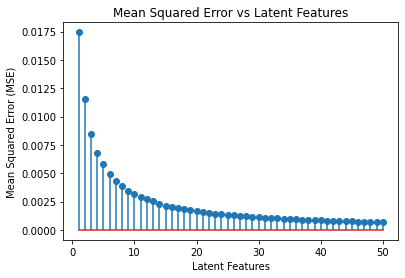

In [438]:
X = latent_features
Y = [test_results[k][2] for k in X]
plt.stem(X, Y)
plt.title('Mean Squared Error vs Latent Features')
plt.xlabel('Latent Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

In [427]:
print(np.dot(user_mat, portfolio_mat))
print(user_item_train)

[[1.03072389 1.03384773 1.01736323 ... 1.02776689 1.00021125 1.02915138]
 [0.8579271  0.84964543 0.8886703  ... 0.85313973 0.85384074 0.83719248]
 [1.26266143 1.24761721 1.26819278 ... 1.25613958 1.26724354 1.2506784 ]
 ...
 [1.10348726 1.13549868 1.09881792 ... 1.14806914 1.14669256 1.13939164]
 [0.96184886 1.00701116 0.99946357 ... 1.02665973 1.00776376 1.01392168]
 [0.88775133 0.87492907 0.87170827 ... 0.87223481 0.87650156 0.86968507]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 0. 1.]]


In [428]:
def predict(df, user_mat, portfolio_mat, user_id, offer_id):
    """
    INPUT:
    df - the source dataset for the test (can be train or test)
    user_mat - user by latent factor matrix from FunkSVD
    protfolio_mat - latent factor by portfolio matrix
    user_id - the user to make prediction for
    offer_id - the offer id
    OUTPUT:
    pred - the prediction for this user and offer based on our model
    """
    try:
        # Lets create the user and portfolio list 
        user_ids = np.array(df.index)
        portfolio_ids = np.array(df.columns)
        
        row = np.where(user_ids == user_id)[0][0]
        col = np.where(portfolio_ids == offer_id)[0][0]
        
        # Now we take the dot product of that row and column in to make prediction
        pred = np.dot(user_mat[row, :], portfolio_mat[:, col])
        
        return pred # return the prediction here
    
    except Exception as e:
        print(e)
        return None
    

In [429]:
user_id = '0009655768c64bdeb2e877511632db8f'
offer_id = '0b1e1539f2cc45b7b9fa7c272da2e1d7'
pred = predict(train_df, user_mat, portfolio_mat, user_id, offer_id)
pred

1.0307238853334493

In [430]:
def test(test_user_item_matrix, user_mat, portfolio_mat):
    """
    We use this to test accuracy of our predictions by measuring
    the sum of squared errors.
    """
    n = np.count_nonzero(~np.isnan(test_user_item_matrix))
    
    # keep track of the sum of squares
    sse = 0
    
    for user_id in test_user_item_matrix.index:
        for offer_id in test_user_item_matrix.columns.values:
            if ~np.isnan(test_user_item_matrix.loc[user_id, offer_id]):
                pred = predict(test_user_item_matrix, user_mat, portfolio_mat, user_id, offer_id)
                if pred:
                    diff = test_user_item_matrix.loc[user_id, offer_id] - pred
                    sse += diff**2
    return sse/n


In [431]:
user_item_test

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0020c2b971eb4e9188eac86d93036a77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fff7576017104bcc8677a8d63322b5e1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fff8957ea8b240a6b5e634b6ee8eafcf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [433]:
validation_set_results = {}
for k in latent_features:
    validation_set_results[k] = test(user_item_test, test_results[k][0], test_results[k][1])
    print(k, validation_set_results[k])

1 0.7889472920433203
2 0.8570125201840139
3 0.8882103620173343
4 0.898658366842574
5 0.9141574571469926
6 0.9112396091245994
7 0.9155412587862766
8 0.928409551880436
9 0.9271546934363273
10 0.9340810185443608
11 0.933323543042515
12 0.9332620356222767
13 0.9362831449947703
14 0.9406014700341349
15 0.9356332835029962
16 0.9382045162337594
17 0.9363924391994649
18 0.9468319776625304
19 0.9388869644964754
20 0.9418238046458988
21 0.9475270352831494
22 0.9426653927073678
23 0.9434269167541992
24 0.9460197495768679
25 0.9487678214892913
26 0.9509480186655461
27 0.9494030863916043
28 0.9487370605664739
29 0.9434357321152841
30 0.9447708175498796
31 0.9463814241914025
32 0.9452190484362669
33 0.953453220009759
34 0.9477693506394338
35 0.9488905755580199
36 0.9425210023992783
37 0.9510580749856367
38 0.9518897836889875
39 0.9546062854522498
40 0.9504917885364847
41 0.9460925028207688
42 0.94987137161274
43 0.946733294390738
44 0.9503395644535195
45 0.9496518593825432
46 0.9530271437255583
47 0

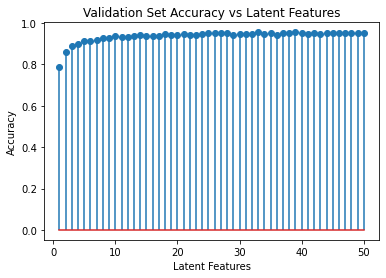

In [439]:
X = latent_features
Y = [validation_set_results[k] for k in latent_features]
plt.stem(X, Y)
plt.title('Validation Set Accuracy vs Latent Features')
plt.xlabel('Latent Features')
plt.ylabel('Accuracy')
plt.show()

In [440]:
def make_offer(df, user_mat, portfolio_mat, user_id):
    """
    Recommend an offer to a user
    """
    offer_bucket = {} # A list of candidate offers for this user
    
    # Make some predictions here
    for offer_id in df.columns:
        pred = predict(df, user_mat, portfolio_mat, user_id, offer_id)
        if pred:
            offer_bucket[offer_id] = [pred, df_portfolio[df_portfolio['id'] == offer_id]]
    return sorted(offer_bucket.items(), key=lambda k:(k[1], k[0]), reverse=True)

In [441]:
# Lets test our offer method
portfolio_offers = make_offer(train_df, test_results[18][0], test_results[18][1], user_id)
portfolio_offers

[('fafdcd668e3743c1bb461111dcafc2a4',
  [0.9302151711176541,
      reward                      channels  difficulty  duration offer_type  \
   6       2  [web, email, mobile, social]          10        10   discount   
   
                                    id  
   6  fafdcd668e3743c1bb461111dcafc2a4  ]),
 ('4d5c57ea9a6940dd891ad53e9dbe8da0',
  [0.9287093129774469,
      reward                      channels  difficulty  duration offer_type  \
   1      10  [web, email, mobile, social]          10         5       bogo   
   
                                    id  
   1  4d5c57ea9a6940dd891ad53e9dbe8da0  ]),
 ('f19421c1d4aa40978ebb69ca19b0e20d',
  [0.9216983808705241,
      reward                      channels  difficulty  duration offer_type  \
   8       5  [web, email, mobile, social]           5         5       bogo   
   
                                    id  
   8  f19421c1d4aa40978ebb69ca19b0e20d  ]),
 ('ae264e3637204a6fb9bb56bc8210ddfd',
  [0.9178979371420529,
      reward   

### <a class="anchor" id="In Conclussion">Part VI : Concluding Remarks</a>
We get some insights into the data and clean up the data.
1. How many offers are in the portfolio